In [38]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [43]:
sequence_length = 60

In [44]:
dataset_path = '../dataset_try'
gesture_labels = sorted(os.listdir(dataset_path))

In [45]:
X = []
y = []
for idx, label in enumerate(gesture_labels):
    folder_path = os.path.join(dataset_path, label)
    if not os.path.isdir(folder_path):
        continue
    
    for file_name in os.listdir(folder_path):
        if not file_name.endswith('.npy'):
            continue
        file_path = os.path.join(folder_path, file_name)
        seq_keypoints = np.load(file_path)
        if seq_keypoints.shape[0] != sequence_length or seq_keypoints.shape[1] != 42:
            continue
        
        X.append(seq_keypoints)
        y.append(idx)

X = np.array(X)
y = np.array(y)

print("Total sequences:", X.shape, y.shape)
print("Gesture labels:", gesture_labels)

Total sequences: (930, 60, 42) (930,)
Gesture labels: ['a', 'b', 'c', 'd', 'delete', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u', 'v', 'x', 'y', 'â', 'ê', 'ô', 'ă', 'đ', 'ơ', 'ư']


Augmentation

In [46]:
def add_jitter(keypoints, sigma=0.01):
    """Thêm nhiễu Gaussian nhẹ vào toàn bộ keypoints"""
    noise = np.random.normal(0, sigma, keypoints.shape)
    return keypoints + noise

In [47]:
def scale_keypoints(keypoints, scale_range=(0.9, 1.1)):
    """Phóng to hoặc thu nhỏ toàn bộ khung keypoints"""
    scale = np.random.uniform(*scale_range)
    return keypoints * scale

In [48]:
def translate_keypoints(keypoints, max_shift=0.05):
    """Dịch chuyển tay trong không gian normalized"""
    shift_x = np.random.uniform(-max_shift, max_shift)
    shift_y = np.random.uniform(-max_shift, max_shift)
    keypoints = keypoints.reshape(-1, 2)
    keypoints += np.array([shift_x, shift_y])
    return keypoints.flatten()

In [49]:
def rotate_keypoints(keypoints, max_angle=15):
    """Xoay toàn bộ keypoints quanh trọng tâm"""
    keypoints = keypoints.reshape(-1, 2)
    center = np.mean(keypoints, axis=0)
    angle = np.radians(np.random.uniform(-max_angle, max_angle))
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                           [np.sin(angle),  np.cos(angle)]])
    rotated = np.dot(keypoints - center, rot_matrix) + center
    return rotated.flatten()

In [50]:
def augment_sequence(sequence):
    """
    Input: sequence (shape = (30, 42)) - 30 frames, mỗi frame 42 toạ độ
    Output: augmented sequence (shape = (30, 42))
    """
    seq = sequence.copy()
    # Áp dụng augmentation cho từng frame
    for i in range(seq.shape[0]):
        frame = seq[i]
        if np.random.rand() < 0.5:
            frame = add_jitter(frame)
        if np.random.rand() < 0.5:
            frame = scale_keypoints(frame)
        if np.random.rand() < 0.5:
            frame = translate_keypoints(frame)
        if np.random.rand() < 0.5:
            frame = rotate_keypoints(frame)
        seq[i] = frame
    return seq

In [51]:
# Augmentation cho toàn bộ tập dữ liệu
aug_X = []
aug_y = []
for i in range(len(X)):
    aug_X.append(X[i])         # dữ liệu gốc
    aug_y.append(y[i])
    # Thêm 1 bản augment cho mỗi sequence (có thể tăng số lượng nếu muốn)
    aug_X.append(augment_sequence(X[i]))
    aug_y.append(y[i])

X = np.array(aug_X)
y = np.array(aug_y)

print("Sau augmentation:", X.shape, y.shape)

Sau augmentation: (1860, 60, 42) (1860,)


Normalize

In [52]:
# Ví dụ tính mean và std của toàn bộ X:
X_flat = X.reshape(-1, 42)          # shape (n_samples * SEQUENCE_LENGTH, 42)
mean = np.mean(X_flat, axis=0, keepdims=True)
std  = np.std(X_flat, axis=0, keepdims=True) + 1e-6

# Áp dụng normalize: (X - mean) / std
X = (X.reshape(-1, 42) - mean) / std
X = X.reshape(-1, sequence_length, 42)

Chia dữ liệu thành train, validation và test

In [53]:
# Bước 1: chia ra train+val (85%) và test (15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

In [54]:
# Bước 2: từ X_trainval lại chia ra train (80% của 85% ≈ 68%) và val (20% của 85% ≈ 17%).
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15/0.85,  # ≈0.176, để val ~15% tổng
    random_state=42, stratify=y_trainval)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1302, 60, 42) (1302,)
Validation: (279, 60, 42) (279,)
Test: (279, 60, 42) (279,)


Mã hóa nhãn

In [55]:
import tensorflow as tf

# Ví dụ với TensorFlow/Keras
num_classes = len(gesture_labels)  # giả sử = 8 (trong ví dụ)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_onehot   = tf.keras.utils.to_categorical(y_val,   num_classes)
y_test_onehot  = tf.keras.utils.to_categorical(y_test,  num_classes)

Xây dựng mô hình

In [56]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

num_classes = len(gesture_labels)    # ví dụ = 8
SEQUENCE_LENGTH = X_train.shape[1]   # ví dụ = 30
NUM_KEYPOINTS = X_train.shape[2]     # ví dụ = 42

In [22]:
# model = models.Sequential([
#     layers.Input(shape=(SEQUENCE_LENGTH, NUM_KEYPOINTS)),

#     # 1 lớp LSTM 128 units
#     layers.LSTM(128, return_sequences=False, name='lstm_1'),
#     layers.Dropout(0.3),

#     # 1–2 lớp Dense để phân loại
#     layers.Dense(64, activation='relu', name='dense_1'),
#     layers.Dropout(0.3),

#     # Output
#     layers.Dense(num_classes, activation='softmax', name='output')
# ])

# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',  # nếu y_train vẫn là integer
#     metrics=['accuracy']
# )

# model.summary()

In [57]:
def build_lstm_model(sequence_length, num_keypoints, num_classes):
    model = models.Sequential([
        # LSTM đầu tiên (trả về toàn bộ sequence để có thể stack LSTM nếu muốn)
        layers.LSTM(128, return_sequences=True, 
                    input_shape=(sequence_length, num_keypoints), 
                    name='lstm_1'),
        layers.Dropout(0.3),

        # LSTM thứ hai (chỉ trả về hidden cuối cùng)
        layers.LSTM(64, return_sequences=False, name='lstm_2'),
        layers.Dropout(0.3),

        # Dense 64 units để học thêm đặc trưng
        layers.Dense(64, activation='relu', name='dense_1'),
        layers.Dropout(0.3),

        # Lớp output
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    return model

model = build_lstm_model(SEQUENCE_LENGTH, NUM_KEYPOINTS, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

c:\Users\PV\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,135 (559.12 KB)

 Trainable params: 143,135 (559.12 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
#  Chuẩn bị các callback
# EarlyStopping: dừng training khi validation loss không giảm trong một số epoch nhất định.
# ModelCheckpoint: lưu mô hình tốt nhất dựa trên val_loss hoặc val_accuracy.

es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,        # nếu 10 epoch liên tiếp val_loss không giảm thì dừng
    restore_best_weights=True,
    verbose=1
)

mc = callbacks.ModelCheckpoint(
    'best_lstm_model.keras',  # file lưu mô hình
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

In [28]:
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     batch_size=32,
#     epochs=50
# )

In [63]:
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=50,
    batch_size=32,
    callbacks=[es, mc, reduce_lr],
    verbose=1
)

Epoch 1/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8908 - loss: 0.4845
Epoch 1: val_loss improved from inf to 0.23083, saving model to best_lstm_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8907 - loss: 0.4836 - val_accuracy: 0.9211 - val_loss: 0.2308 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9037 - loss: 0.2477
Epoch 2: val_loss improved from 0.23083 to 0.13292, saving model to best_lstm_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9042 - loss: 0.2473 - val_accuracy: 0.9749 - val_loss: 0.1329 - learning_rate: 0.0010
Epoch 3/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9664 - loss: 0.1418
Epoch 3: val_loss improved from 0.13292 to 0.07623, saving model to best_lstm_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9662 - loss: 0.1419 - val_accuracy: 0.9785 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accur

In [64]:
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 3.8951e-04
Test accuracy: 1.0000, Test loss: 0.0004


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 800x800 with 0 Axes>

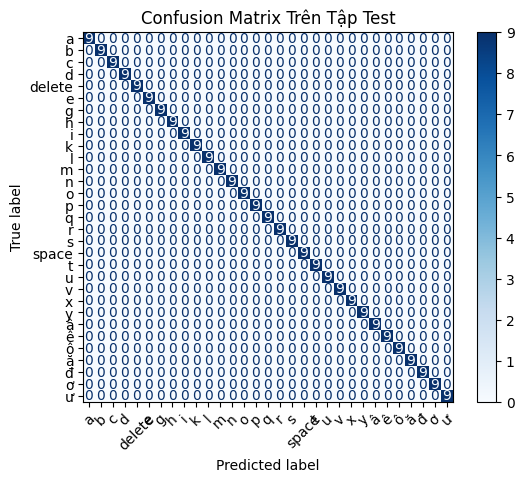

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dự đoán
y_pred_probs = model.predict(X_test)        # shape: (num_test, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gesture_labels)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix Trên Tập Test")
plt.show()

In [66]:
model.save('model_tf3.keras')

In [67]:
np.save('mean.npy', mean)
np.save('std.npy', std)